# SKlearn 机器学习单个票并回测

## 初始化

In [64]:
#常规库引用
import datetime
import tushare as ts
# import rqalpha_data
import pandas as pd
import numpy as np
import tushare as ts
import baostock as bs
import talib as talib
import seaborn as sns
from sklearn.externals import joblib   #保存模型方法
import time
#保存模型
#joblib.dump(model,'rf.model')
#加载模型
#model=joblib.load('rf.model')

import math
import statsmodels.tsa.stattools as stattool
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (18.0, 6.0)

In [65]:
#mysqld调用
# from sqlalchemy import create_engine
# engine = create_engine("mysql+pymysql://{}:{}@{}/{}?charset={}".format('root', '12345678', '127.0.0.1:3306', 'finance','utf8'))
# conn = engine.connect()#创建连接


In [66]:
#调用接口函数
def addcode(c): #在代码后载入sz，sh
    return c+'.sh'  if c[0:1]=='6' else c+'.sz' 
def precode(c): #在代码后载入sz，sh
    return 'sh.'+c  if c[0:1]=='6' else 'sz.'+c 

def getBaostock(pcode,start_date,end_date,datatype):
#     print(code)
    rs = bs.query_history_k_data_plus(pcode,
    "date,code,close,open,low,high,volume,amount",  #preclose,turn,
    start_date=start_date, end_date=end_date,
    frequency=datatype, adjustflag="3")#复权类型选择123
    #### 打印结果集 ####
    data_list = []
    
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        data_list.append(rs.get_row_data())

    df=pd.DataFrame(data_list, columns=rs.fields)
    df.close=pd.to_numeric(df.close, downcast='float')
    df.open=pd.to_numeric(df.open, downcast='float')
    df.low=pd.to_numeric(df.low, downcast='float')
    df.high=pd.to_numeric(df.high, downcast='float')
#     df.preclose=pd.to_numeric(df.preclose, downcast='float')
#     df.turn=pd.to_numeric(df.turn, downcast='float')
    df.amount=pd.to_numeric(df.amount, downcast='float')
    df.volume=pd.to_numeric(df.volume,downcast='float')
    df.dropna(inplace=True)
    return df


In [67]:
lg = bs.login()
# 显示登陆返回信息
start_date='2013-01-01'
today=time.strftime('%Y-%m-%d',time.localtime(time.time()))
print('login respond  msg:'+lg.error_msg)
i=0
code='600256'

df=getBaostock(precode(code),start_date,today,'60')  # 获取个股2013年至今60min数据，即每小时一行，一共6000多行
df.code=code

if df.shape[0]>0:
    df.to_csv(code+'.csv',index=False)
else:
    print(code+' empty data')
   
bs.logout()
df.tail(2)  

login success!
login respond  msg:success
logout success!


,date,code,close,open,low,high,volume,amount
6562,2019-11-28,600256,3.24,3.26,3.24,3.26,1719240.0,5593722.0
6563,2019-11-28,600256,3.24,3.24,3.23,3.25,2395580.0,7768348.0


In [5]:
# 从中获取数据,并增加集合学习数据
price=pd.read_csv(code+'.csv')
print('lastdata',price.date.iloc[-1])
price.drop(['date','code'],axis=1,inplace=True)
price.tail(2)

lastdata 2019-11-28


,close,open,low,high,volume,amount
6562,3.24,3.26,3.24,3.26,1719240.0,5593722.0
6563,3.24,3.24,3.23,3.25,2395580.0,7768348.0


price_train (6314, 79) ,price_test (138, 79) ,price_last (12, 79)


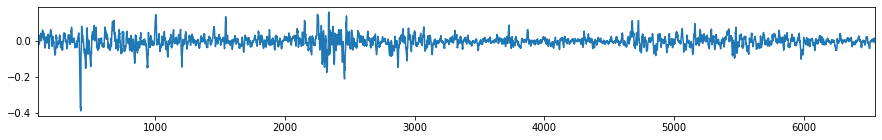

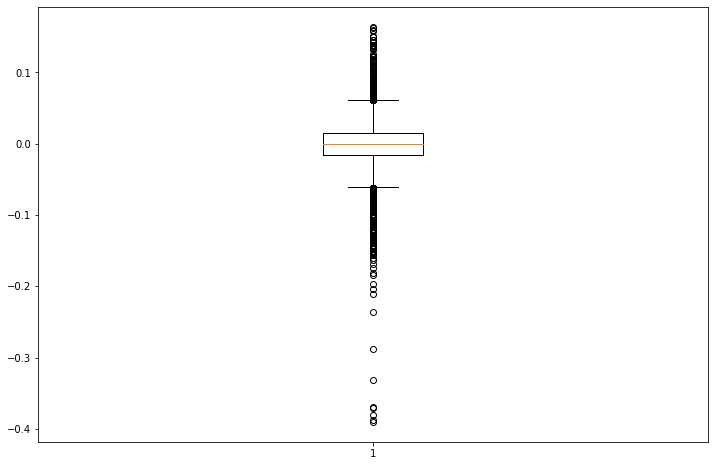

In [6]:
import newfeature
y=price['close'].rolling(8).mean().shift(periods=-12, axis=0)/price['close']-1 # 9日最大涨幅(应该是买入后未来第5到第12日的平均收益率吧)

xprice_feature=newfeature.getStockCharacter(price).astype('float16')[100:]
xprice_feature.drop(['adline'],axis=1,inplace=True)  # adline这列不知道为何，全部都是inf

y_p_train=y[100:-150]
y_p_test=y[-150:-12]
y_p_all=y[100:-12]

# xprice_feature.drop(['alpha_144','adline'],axis=1,inplace=True)
xprice_feature=xprice_feature*0.3/xprice_feature.std()  # 数据标准化处理，这里直接乘0.3，再除以标准差
xprice_feature.dropna(axis=1,inplace=True)
price_all=(xprice_feature[:-12])
price_train=(xprice_feature[:-150])  # 1991到2018年数据做训练集，剔除最早100个数据，因为在数据处理时，可能导致出现很多空值

price_test=(xprice_feature[-150:-12])  # 最近150日数据做测试集，剔除最后12个数，因为无法预测未来值，即没有标签值。
price_last=(xprice_feature[-12:])  # 最近12日数据，因为一些特征所需因素尚未发生，故不能作为测试集
xprice_feature.to_csv('xmm.csv')
print('price_train',price_train.shape,',price_test',price_test.shape,',price_last',price_last.shape)  # 1991-2019差不多6000个交易日
# print(y)
y_p_all.plot(figsize=(15,2))
xprice_feature.head(2)
y_p_all.describe()

fig,ax = plt.subplots(figsize=(12,8))
ax.boxplot(y_p_all.values)
plt.show()

## 读取数据完毕，查看数据分布特性，并对结果进行切割分类,非必要

In [7]:
# 查看极值
pric=pd.DataFrame()
pric['max']=price_train.max(axis=0)
pric['min']=price_train.min(axis=0)
pric['median']=price_train.median(axis=0)
pric['mean']=price_train.mean(axis=0)
pric['count']=price_train.count(axis=0)
# pric[150:200]
# print(pric.index[43])
# pric.values.argmin(axis=0)
# abcd = pric.iloc(pric.values.argmin(axis=0))
# print(abcd)
# print(pric["min"]<-10)
# print(pric.min(axis=0))

C:\Users\Administrator\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### 查看离散度分布

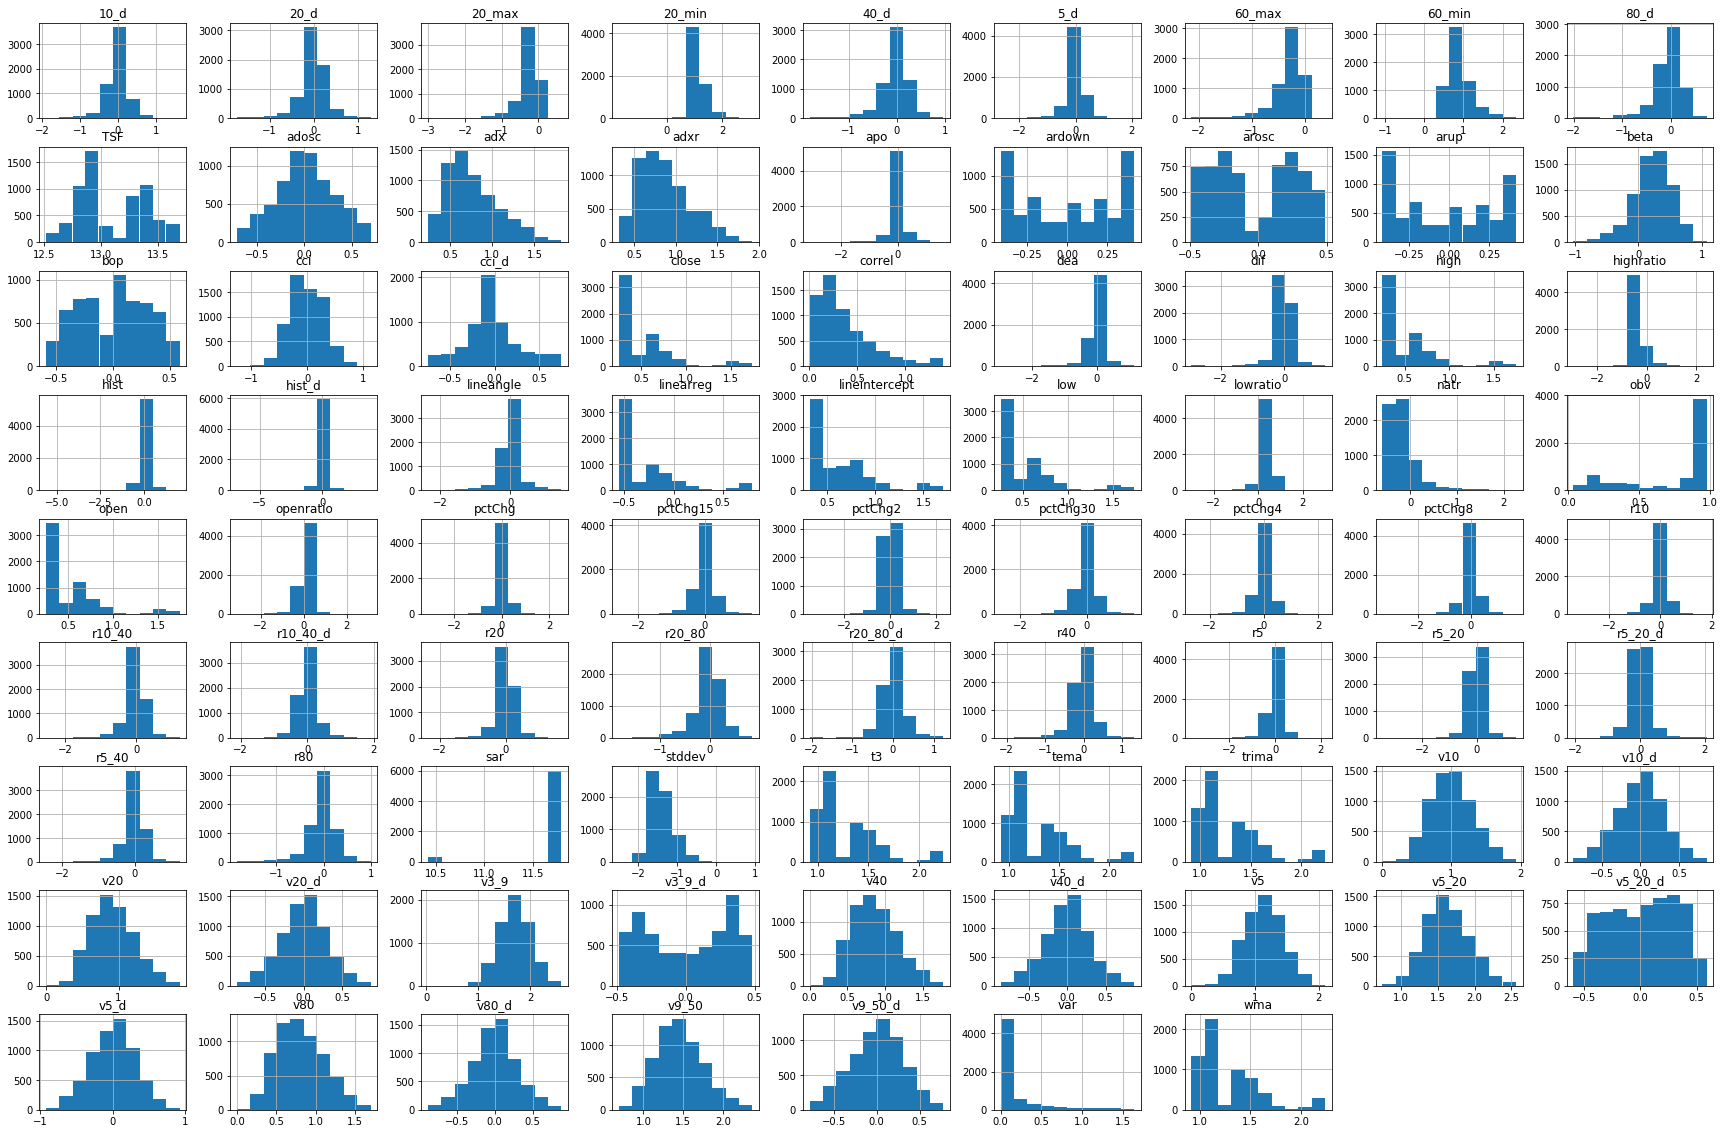

In [8]:
# 查看离散度分布,暂时不需要
# print(price_train.shape)
# x=0*100
x=0

# price_train = price_train.astype(np.float64)
# price_train.describe()

plt.rcParams['figure.figsize'] = (30.0, 20.0)
price_train.iloc[:,x:x+100].hist(bins=10)
plt.show()


### 数据切割成分类

In [9]:
#按照分位数进行切分，避免分了不平均问题发生
def get_quantiles(data,x):    
    c_bins=np.r_[-100,[np.round(np.quantile(data, i/x),3) for i in range(1,x)],100]  # 1/5,2/5,3/5,4/5,1   
    print(np.floor(100*c_bins))  # 五分位后，取整后的结论为，五分位上的各自涨幅-4%,-2%,0, 1%, 3%
    return c_bins

bins=get_quantiles(y_p_all,6) # bins.shape(7,1)

y_train=pd.cut(y_p_train, bins, right=False,labels=False)  # 按分位数，进行分类，分为6类
y_test=pd.cut(y_p_test, bins, right=False,labels=False)
y_all=pd.cut(y_p_all, bins, right=False,labels=False)

from sklearn.model_selection import train_test_split

X_train_ori, X_validate_ori, y_train, y_validate = train_test_split(price_train,y_train,test_size=0.4, random_state=10,stratify=y_train)

print(X_train_ori.shape,y_train.shape,X_validate_ori.shape,y_validate.shape,price_test.shape,y_test.shape)
y_train

[-1.e+04 -3.e+00 -1.e+00 -0.e+00  0.e+00  2.e+00  1.e+04]
(3788, 79) (3788,) (2526, 79) (2526,) (138, 79) (138,)


4862    0
1192    5
1076    3
555     0
2695    5
       ..
3940    3
1966    2
721     5
5595    5
2768    3
Name: close, Length: 3788, dtype: int64

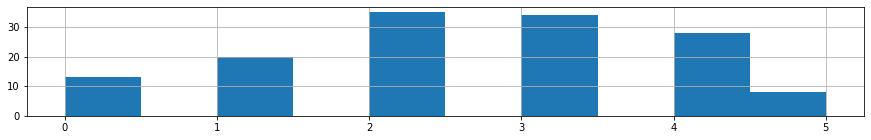

In [10]:
plt.rcParams['figure.figsize'] = (15.0, 2.0)
y_test.hist()
# price_train

### 数据维度组合分析图表

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Administrator\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


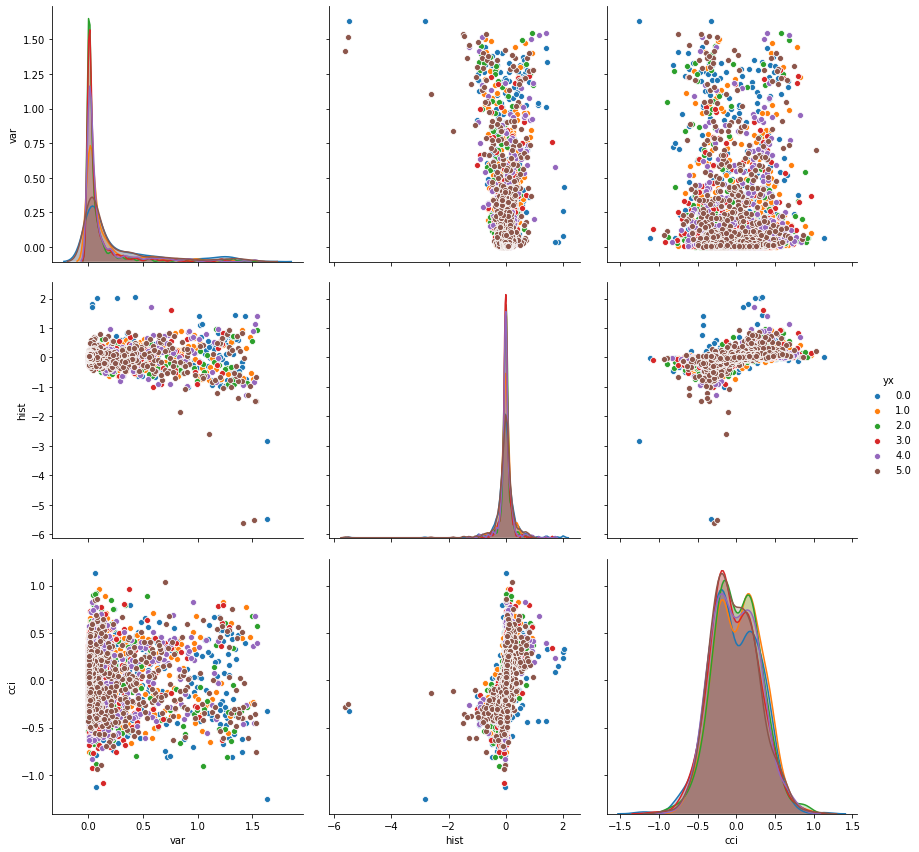

In [11]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (30.0, 4.0)
price_train['yx']=y_train
#维度组合图表
# vars=['var','hist','cci','5_d','cci_d','t3','natr']
_ = sns.pairplot(price_train.iloc[:], vars=['var','hist','cci'], hue="yx", height=4)
price_train.drop(['yx'],axis=1,inplace=True)  # 绘图临时把标签列y_train加进来，画完图踢掉

# price_test.groupby('resultRel')['r5'].count()


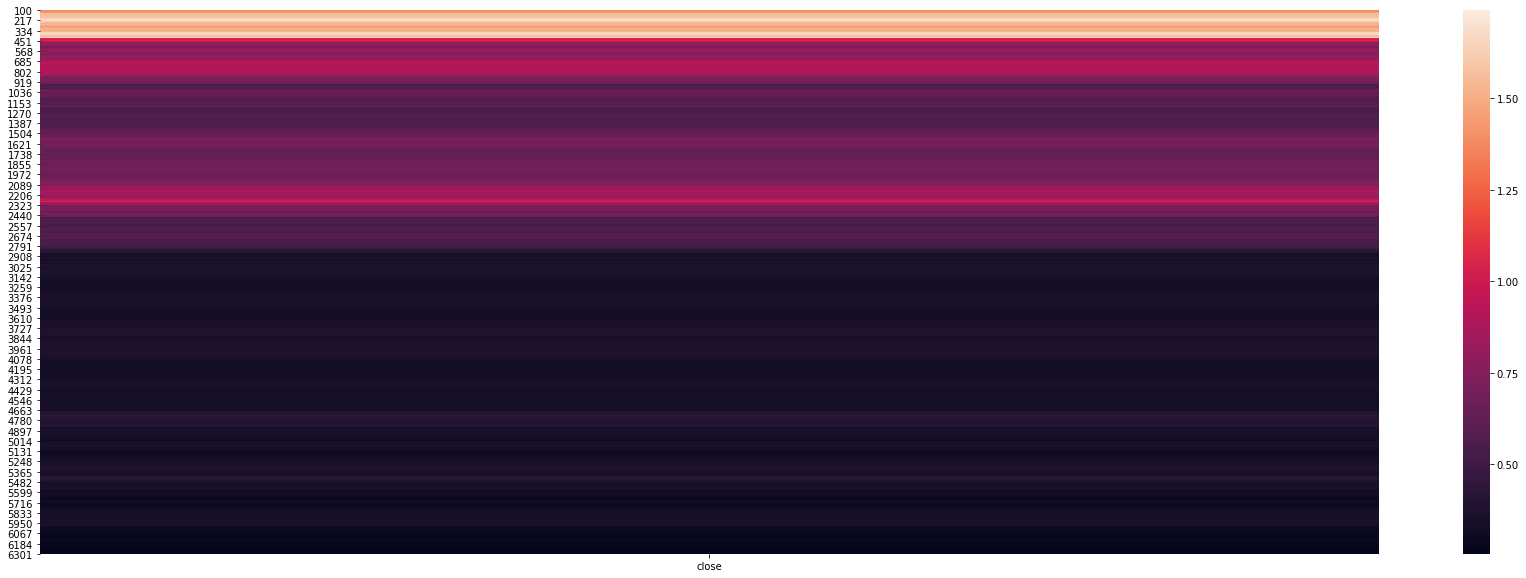

In [12]:
plt.figure(figsize=(30, 10))
_ = sns.heatmap(price_train[["close"]])

In [13]:
print(price_train.dtypes)
# price_train(np.isnan(price_train))


close     float16
open      float16
low       float16
high      float16
pctChg    float16
           ...   
arup      float16
arosc     float16
bop       float16
cci       float16
cci_d     float16
Length: 79, dtype: object


### 数据降维处理，300+降到70维

In [14]:
#PCA 降维处理
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(price_all)
X_all=pca.transform(price_all)
X_test=pca.transform(price_test)
X_train=pca.transform(X_train_ori)
X_last=pca.transform(price_last)
X_validate=pca.transform(X_validate_ori)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_validate.shape,y_validate.shape,X_last.shape)


(3788, 50) (3788,) (138, 50) (138,) (2526, 50) (2526,) (12, 50)


## 数据集训练

In [15]:
#训练函数
%timeit

from sklearn.tree import DecisionTreeClassifier
import sklearn.ensemble as ensemble
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import fbeta_score , accuracy_score
import time
def acc_n(b,a):#自定义打分函数，解决相邻问题,b实际值，a预测值
    a_add1=a+1
    a_pdd1=a-1
    x=((a_add1==b)*0.6).sum()+((a_pdd1==b)*0.6).sum()+((a==b)*1).sum() # 预测结果在真实值上下两个相邻分类，也认为是预测成功
    return x/len(a)

#自定义函数，计算当预测涨幅为最大归类时的准确率，b实际值，a预测值
def acc_top(b,a):
    len_predict=0
    len_right=0
    for x in range(len(a)):  # 只统计我预测股价会涨3%，结果实际涨3%，1%。。。的情况，给不同权重
        if a[x]==a.max(): #预测最大值归类，要求大于0
            len_predict+=1
            if a[x]==b[x]: #完全正确
                len_right+=1
            if a[x]-1==b[x]:  #降低一档正确
                len_right+=0.5
            if a[x]-2==b[x]:  #降低2档正确，这个是个过渡区间，没有达到最大预期，但是在不错的区间
                len_right+=0.1
            if a[x]-3==b[x]:  #降低3档正确
                len_right+=-0.1
            if a[x]-4==b[x]:  #降低4档正确
                len_right+=-0.5
            if a[x]-5==b[x]:  #降低5档正确
                len_right+=-1
                
    return len_right/len_predict

#利用模型训练，返回准确率

def train_fit(learner, sample_size, X_train, y_train, X_test, y_test): 
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    
    predictions_train = learner.predict(X_train)
    predictions_test =learner.predict(X_test)

    test_accuracy=np.round([accuracy_score(y_train,predictions_train),accuracy_score(y_test,predictions_test),
                            acc_n(y_train,predictions_train),acc_n(y_test,predictions_test),
                            acc_top(y_train,predictions_train),acc_top(y_test,predictions_test)],3)
    return test_accuracy

#分类器组进行训练，返回每种算法模型的准确率组合(训练集准确率，测试集准确率，训练集accn得分，测试集accn得分，训练集acc_top得分，测试集acc_top得分
def clfs_fit(clfs,x_validate_pr,y_validate,x_test_pr,y_test,clfs_class=0):
    accuracy_result=[]
    for clf in clfs: 
        clf_name = clf[0]    
        start=time.time()
        print(clf_name,time.strftime('%H:%M:%S', time.localtime()))
        test_accuracy = train_fit(clf[1], y_validate.shape[0], x_validate_pr, y_validate.values, x_test_pr, y_test.values)
        #判断保存
        if clfs_class>0: 
            joblib.dump(clf[1],clf[0]+str(clfs_class)+'.model')

        accuracy_result.append([test_accuracy[0],test_accuracy[1],
                               test_accuracy[2],test_accuracy[3],
                               test_accuracy[4],test_accuracy[5]])        
        print(clf[0],'train acc:',test_accuracy[0],'test acc:',test_accuracy[1],'train score',test_accuracy[2],'test score:',test_accuracy[3],'train topacc',test_accuracy[4],'test topacc:',test_accuracy[5],' cost sec:',round(time.time()-start,2))
    return accuracy_result

# #召回率，准确率，交叉矩阵等结果指标分析
from sklearn.metrics import f1_score,precision_score,recall_score,classification_report,confusion_matrix
# ya=assemble_predict_v_test.true.values
# yp=assemble_predict_v_test[0].values
def get_acc_data(ya,yp):
    f1score=f1_score(ya, yp, average='weighted')
    prescore=precision_score(ya,yp, average='weighted')
    rscore=recall_score(ya,yp,average='weighted')
    score_n=acc_n(ya,yp)
    score_top=acc_top(ya,yp)
    cmatrix=confusion_matrix(ya,yp)
    # creport=classification_report(ya,yp)
    return np.round([f1score,prescore,rscore,score_n,score_top],3)

### 决策树网格搜索


### 初始化一级机器学习分类器


In [16]:
#使用gridsearch进行网格搜索，暂时不需要
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

regressor = DecisionTreeClassifier(random_state=0,criterion='gini')  # 创建决策树对象
#从以下参数中选取最优
parameters = {'max_depth': range(5, 10),
              "max_features": [10, 20, 30,40,50],
              "min_samples_split": [2, 5, 10, 20],
              "min_samples_leaf": [2, 5, 10, 20]
             }

scoring_fnc = make_scorer(accuracy_score)
scoring_fnc = make_scorer(acc_n)
kfold = KFold(n_splits=10)
grid = GridSearchCV(regressor, parameters, scoring_fnc,n_jobs=-1,cv=kfold)
grid = grid.fit(X_train, y_train)
reg = grid.best_estimator_
 




In [17]:
print(grid.cv_results_["params"][3])

print('best score: %f'%grid.best_score_)
reg.get_params()

{'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 20}
best score: 0.424287


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 30,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

In [18]:
for key in parameters.keys():
    print('%s: %d'%(key, reg.get_params()[key]))

print('test score: %f'%reg.score(X_test, y_test))

# pd.DataFrame(grid.cv_results_).T
max_depth=reg.get_params()['max_depth']
max_features=reg.get_params()['max_features']
min_samples_split=reg.get_params()['min_samples_split']
min_samples_leaf=reg.get_params()['min_samples_leaf']
# print(max_depth)

max_depth: 8
max_features: 30
min_samples_split: 20
min_samples_leaf: 5
test score: 0.224638


In [19]:
#初始化一级机器学习分类器

clfs = [
        ['KNeighbors',KNeighborsClassifier(20)],
        ['MLP',MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
                               beta_2=0.999, early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(15,), learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200, momentum=0.9,
                               nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
                               solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
                               warm_start=False)],
# #         ['SVClinear',SVC(kernel="linear", C=0.025,probability=True)],
# #         ['SVCgamma2',SVC(gamma=2, C=1,probability=True)],
        ['SVCrbf',SVC(kernel = 'rbf',probability=True)],
# #         ['GaussianProcess',GaussianProcessClassifier(1.0 * RBF(1.0))],#高斯过程当维度>30时，效率很低，不建议使用
        ['DecisionTree',DecisionTreeClassifier(max_depth=max_depth,criterion='gini',
                                                                             random_state=0,
                                                                            max_features=max_features,
                                                                            min_samples_split=min_samples_split,
                                                                            min_samples_leaf=min_samples_leaf)],
##         ['LinearDiscriminant',  LinearDiscriminantAnalysis()],
##         ['QuadraticDiscriminant',QuadraticDiscriminantAnalysis()], 
        ['XGBoost',XGBClassifier(learning_rate=0.1,n_estimators=500,         # 树的个数--500棵树建立xgboost
                                max_depth=8,min_child_weight = 1,      # 叶子节点最小权重
                                gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                                subsample=0.6,             # 随机选择80%样本建立决策树
                                colsample_btree=0.6,       # 随机选择80%特征建立决策树
                                objective='multi:softmax', # 指定损失函数
                                scale_pos_weight=1,        # 解决样本个数不平衡的问题
                                random_state=27,           # 随机数
                               n_jobs=-1)],
         ['AdaBoost_DTree',ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,criterion='gini',
                                                                             random_state=0,
                                                                            max_features=max_features,
                                                                            min_samples_split=min_samples_split,
                                                                            min_samples_leaf=min_samples_leaf),
                          n_estimators=400, random_state=1)],
         ['RandomForest',ensemble.RandomForestClassifier(n_estimators=1000, random_state=1,n_jobs=-1)],
         ['AdaBoost_samme',ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,criterion='gini',
                                                                             random_state=0,
                                                                            max_features=max_features,
                                                                            min_samples_split=min_samples_split,
                                                                            min_samples_leaf=min_samples_leaf),
                         algorithm="SAMME", n_estimators=400, learning_rate=0.8)],
        ['ExtraTrees', ensemble.ExtraTreesClassifier(n_estimators=1000, max_depth=None,n_jobs=-1)],  # clf.feature_importances_
        ['GradientBoost', ensemble.GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, max_depth=8, random_state=0)], # clf.feature_importances_
#         ['Bagging',ensemble.BaggingClassifier(max_features=50,max_samples=20, bootstrap_features=True, oob_score=True,n_jobs=-1)]
        ]

index = np.array(clfs)[:,0]

### 调用一级分类器模型学习train_set


In [20]:

accuracy_result=pd.DataFrame(clfs_fit(clfs,X_train,y_train,X_validate,y_validate,0))
accuracy_result.columns=['train_acc','validate_acc','train_sccore','validate_score','train_top','validate_top']


KNeighbors 20:25:52
KNeighbors train acc: 0.397 test acc: 0.273 train score 0.539 test score: 0.449 train topacc 0.318 test topacc: 0.26  cost sec: 2.32
MLP 20:25:55
MLP train acc: 0.423 test acc: 0.29 train score 0.591 test score: 0.47 train topacc 0.475 test topacc: 0.244  cost sec: 0.85
SVCrbf 20:25:55


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVCrbf train acc: 0.288 test acc: 0.268 train score 0.457 test score: 0.442 train topacc 0.167 test topacc: 0.158  cost sec: 14.62
DecisionTree 20:26:10
DecisionTree train acc: 0.393 test acc: 0.251 train score 0.526 test score: 0.428 train topacc 0.271 test topacc: 0.182  cost sec: 0.16
XGBoost 20:26:10
XGBoost train acc: 1.0 test acc: 0.341 train score 1.0 test score: 0.518 train topacc 1.0 test topacc: 0.339  cost sec: 28.8
AdaBoost_DTree 20:26:39
AdaBoost_DTree train acc: 1.0 test acc: 0.281 train score 1.0 test score: 0.464 train topacc 1.0 test topacc: 0.25  cost sec: 54.26
RandomForest 20:27:33
RandomForest train acc: 1.0 test acc: 0.364 train score 1.0 test score: 0.545 train topacc 1.0 test topacc: 0.409  cost sec: 7.4
AdaBoost_samme 20:27:41
AdaBoost_samme train acc: 1.0 test acc: 0.327 train score 1.0 test score: 0.503 train topacc 1.0 test topacc: 0.31  cost sec: 57.13
ExtraTrees 20:28:38
ExtraTrees train acc: 1.0 test acc: 0.397 train score 1.0 test score: 0.576 train topa

In [21]:
accuracy_result.index = index
accuracy_result

,train_acc,validate_acc,train_sccore,validate_score,train_top,validate_top
KNeighbors,0.397,0.273,0.539,0.449,0.318,0.260
MLP,0.423,0.290,0.591,0.470,0.475,0.244
SVCrbf,0.288,0.268,0.457,0.442,0.167,0.158
DecisionTree,0.393,0.251,0.526,0.428,0.271,0.182
XGBoost,1.000,0.341,1.000,0.518,1.000,0.339
AdaBoost_DTree,1.000,0.281,1.000,0.464,1.000,0.250
RandomForest,1.000,0.364,1.000,0.545,1.000,0.409
AdaBoost_samme,1.000,0.327,1.000,0.503,1.000,0.310
ExtraTrees,1.000,0.397,1.000,0.576,1.000,0.533
GradientBoost,1.000,0.274,1.000,0.452,1.000,0.195


In [23]:
mm=pd.DataFrame()
mylist = []

for clf in clfs: 
    v_predict=clf[1].predict(X_validate)
    t_predict=clf[1].predict(X_test)
    mm[clf[0]]=t_predict  # 保存每种模型的训练集预测结果
    mylist.append(np.r_[get_acc_data(v_predict,y_validate.values),get_acc_data(t_predict,y_test.values)])


columns = ["validate_f1score","validate_prescore","validate_rscore","validate_score_n","validate_score_top", "test_f1score","test_prescore","test_rscore","test_score_n","test_score_top"] 
df3 = pd.DataFrame(mylist,columns=columns,index=index)
df3

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.

,validate_f1score,validate_prescore,validate_rscore,validate_score_n,validate_score_top,test_f1score,test_prescore,test_rscore,test_score_n,test_score_top
KNeighbors,0.274,0.279,0.273,0.449,0.130,0.220,0.244,0.203,0.446,0.025
MLP,0.301,0.320,0.290,0.470,0.374,0.261,0.367,0.210,0.493,0.025
SVCrbf,0.273,0.298,0.268,0.442,0.152,0.355,0.555,0.268,0.490,-0.025
DecisionTree,0.258,0.274,0.251,0.428,0.125,0.267,0.382,0.225,0.455,-0.075
XGBoost,0.344,0.349,0.341,0.518,0.328,0.303,0.372,0.261,0.483,0.100
AdaBoost_DTree,0.280,0.284,0.281,0.464,0.244,0.198,0.242,0.174,0.452,0.075
RandomForest,0.370,0.384,0.364,0.545,0.339,0.302,0.465,0.232,0.497,-0.000
AdaBoost_samme,0.325,0.325,0.327,0.503,0.295,0.321,0.422,0.275,0.484,-0.075
ExtraTrees,0.401,0.414,0.397,0.576,0.433,0.325,0.497,0.254,0.506,0.075
GradientBoost,0.274,0.273,0.274,0.452,0.168,0.214,0.212,0.217,0.435,0.050


In [24]:
pd.DataFrame(confusion_matrix(y_test.values,mm[clfs[5][0]]))  # 混淆矩阵，观察AdaBoost_DTree模型预测成功失败的分布

,0,1,2,3,4,5
0,0,1,9,2,1,0
1,0,0,10,7,3,0
2,1,1,9,20,4,0
3,0,0,18,7,9,0
4,0,0,17,3,8,0
5,0,0,5,1,2,0


In [25]:
# # 从文件中导入模型，如果不是已经有模型了，不用
# clfs=[]
# clf_names=['KNeighbors', 'MLP', 'SVCrbf', 'XGBoost', 'AdaBoost_DTree',
#        'RandomForest', 'AdaBoost_samme', 'ExtraTrees', 'GradientBoost',
#        'Bagging']
          
# for clf_name in clf_names: 
#     clfs.append([clf_name,joblib.load(u''+clf_name+'1.model')])


In [26]:
#单独保存模型，暂时不需要
# for clf in clfs: 
#     joblib.dump(clf[1],clf[0]+'.model')


In [27]:
#对test_set进行预测，计算预测正确率，并将正确率作为集合学习的train_dataset
def get_assemble_data(clfs,X,proba=0): #proba=1则使用predict_proba预测
    x=pd.DataFrame()
    for i in range(len(clfs)):
        if proba==0:
            p_predict=clfs[i][1].predict(X)
            x[i]=p_predict
        else:
            p2_predict=clfs[i][1].predict_proba(X)  # 获取每种模型的概率分布，二维列表，内层列表是一个样本一个子列表
            for ii in range(len(bins)-1):
                x['b'+str(ii)+str(i)]=p2_predict[:,ii]  
                # 不同模型预测出的每个样本属于不同类别的概率分布。10个模型,6种标签类别,就是60列
    return x


x_train_pr=get_assemble_data(clfs,X_train,1)
x_test_pr=get_assemble_data(clfs,X_test,1)
x_validate_pr=get_assemble_data(clfs,X_validate,1)
x_last_pr=get_assemble_data(clfs,X_last,1)
x_test_pr

,b00,b10,b20,b30,b40,b50,b01,b11,b21,b31,...,b28,b38,b48,b58,b09,b19,b29,b39,b49,b59
0,0.10,0.05,0.50,0.10,0.15,0.10,0.036025,0.111724,0.221745,0.226644,...,0.220,0.269,0.218,0.110,0.002824,0.019419,0.353474,0.033085,0.489283,0.101915
1,0.00,0.00,0.25,0.30,0.25,0.20,0.006594,0.101737,0.340443,0.280576,...,0.226,0.225,0.230,0.131,0.000015,0.000071,0.782670,0.196755,0.020074,0.000415
2,0.05,0.15,0.10,0.25,0.30,0.15,0.011167,0.079252,0.326739,0.297806,...,0.166,0.225,0.194,0.147,0.006658,0.000282,0.568655,0.382653,0.039946,0.001806
3,0.00,0.25,0.10,0.30,0.20,0.15,0.004001,0.063803,0.344764,0.360152,...,0.181,0.283,0.208,0.112,0.000463,0.002516,0.011958,0.934599,0.050380,0.000085
4,0.00,0.10,0.25,0.20,0.40,0.05,0.023864,0.109777,0.342753,0.306610,...,0.197,0.287,0.228,0.114,0.000854,0.006739,0.195441,0.790735,0.004882,0.001348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.10,0.35,0.05,0.20,0.10,0.20,0.016648,0.144640,0.295398,0.275867,...,0.228,0.230,0.130,0.123,0.015405,0.912642,0.034973,0.020947,0.000998,0.015036
134,0.15,0.25,0.25,0.20,0.10,0.05,0.015331,0.182272,0.289314,0.128618,...,0.240,0.233,0.189,0.075,0.000254,0.999487,0.000132,0.000093,0.000016,0.000017
135,0.00,0.25,0.40,0.25,0.00,0.10,0.010922,0.131033,0.538593,0.195154,...,0.235,0.237,0.147,0.120,0.033141,0.311805,0.561136,0.058692,0.033422,0.001804
136,0.15,0.10,0.35,0.20,0.05,0.15,0.017085,0.183030,0.314799,0.261453,...,0.256,0.244,0.124,0.115,0.428536,0.012393,0.013850,0.106983,0.431937,0.006301


In [28]:
# 对各个模型计算出来的结果进行集合学习,二次学习
%timeit

assembles_1 = [
              ['KNeighbors',KNeighborsClassifier(10)],
#               ['DecisionTree',DecisionTreeClassifier(random_state=0,max_depth=10,criterion='gini')],
              ['SVC',SVC(kernel = 'rbf',probability=True)],
#               ['LinearDiscriminant',  LinearDiscriminantAnalysis()],
              ['AdaBoost',ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,criterion='gini'),
                            n_estimators=100, random_state=1)],
              ['RandomForest',ensemble.RandomForestClassifier(n_estimators=100, random_state=1)],
              ['AdaBoost2',ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=2),
                           algorithm="SAMME", n_estimators=100, learning_rate=0.8)]
            ]

        
acc_assemble=clfs_fit(assembles_1,x_validate_pr,y_validate,x_test_pr,y_test,0)  
# x_validate_pr经过第一次学习的学习器，已经生成了一堆的概率分布，不知道这里为啥要重新进行一次训练。。。。。。
# acc_assemble=clfs_fit(assembles_1,x_validate_pr,y_validate,x_test_pr,y_test,0)
acc_assemble

KNeighbors 20:30:09
KNeighbors train acc: 0.439 test acc: 0.217 train score 0.581 test score: 0.457 train topacc 0.555 test topacc: -0.5  cost sec: 1.19
SVC 20:30:10


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC train acc: 0.356 test acc: 0.181 train score 0.535 test score: 0.442 train topacc 0.417 test topacc: 0.232  cost sec: 7.94
AdaBoost 20:30:18
AdaBoost train acc: 0.619 test acc: 0.217 train score 0.742 test score: 0.409 train topacc 0.847 test topacc: -0.2  cost sec: 7.36
RandomForest 20:30:25
RandomForest train acc: 1.0 test acc: 0.246 train score 1.0 test score: 0.49 train topacc 1.0 test topacc: -0.5  cost sec: 1.88
AdaBoost2 20:30:27
AdaBoost2 train acc: 0.521 test acc: 0.261 train score 0.67 test score: 0.461 train topacc 0.65 test topacc: -0.1  cost sec: 7.12


[[0.439, 0.217, 0.581, 0.457, 0.555, -0.5],
 [0.356, 0.181, 0.535, 0.442, 0.417, 0.232],
 [0.619, 0.217, 0.742, 0.409, 0.847, -0.2],
 [1.0, 0.246, 1.0, 0.49, 1.0, -0.5],
 [0.521, 0.261, 0.67, 0.461, 0.65, -0.1]]

In [29]:
#根据二次学习结果打印输出权重矩阵
weight_assemble=pd.DataFrame(acc_assemble).iloc[:,3]-0.92/5
weight_assemble=weight_assemble/weight_assemble.sum()  # 各模型的训练集acc_n分数，归一化，比较各模型的效果
weight_assemble.values

array([0.2038835 , 0.19268111, 0.16803585, 0.22852875, 0.2068708 ])

In [37]:
# 对二次学习的各算法，进行预测，输出预测结果
mm=pd.DataFrame()
for clf in assembles_1:  
    t_predict=clf[1].predict(x_test_pr)
    mm[clf[0]]=t_predict
pred=np.dot(mm,weight_assemble)  # 各模型输出结果，乘以各自模型的效果，得到加权的最终结果（四舍五入变为整数）
pd.DataFrame(confusion_matrix(y_test.values, np.round(pred,0)))  

,0,1,2,3,4,5
0,0,1,9,3,0,0
1,0,1,8,10,1,0
2,0,0,20,14,1,0
3,0,1,15,17,1,0
4,0,0,19,8,1,0
5,0,1,5,2,0,0


### 预测近2日趋势

In [39]:
#利用所有样本数据进行学习
accuracy_result=clfs_fit(clfs,X_all,y_all,X_test,y_test,0)
#二次学习模型决策（用最后12日数据进行决策）
x_last_end_pr=get_assemble_data(clfs,X_last,1)  # 用第一次的10种模型进行预测，得出10种模型对6种分类分别的概率，一共60列
mm=pd.DataFrame()
for clf in assembles_1:  # 把第一次得到的概率分布，再用第二次的5种模型进行预测，得到预测结果
    t_predict=clf[1].predict(x_last_end_pr)
    mm[clf[0]]=t_predict
mm['mean']=np.dot(mm,weight_assemble)  # 加权平均各模型预测值，得到每个样本最终预测值



KNeighbors 21:10:28
KNeighbors train acc: 0.418 test acc: 0.37 train score 0.567 test score: 0.578 train topacc 0.452 test topacc: 0.167  cost sec: 4.45
MLP 21:10:32
MLP train acc: 0.398 test acc: 0.362 train score 0.588 test score: 0.61 train topacc 0.511 test topacc: 0.632  cost sec: 1.39
SVCrbf 21:10:34


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVCrbf train acc: 0.293 test acc: 0.297 train score 0.459 test score: 0.514 train topacc 0.204 test topacc: 0.47  cost sec: 42.59
DecisionTree 21:11:16
DecisionTree train acc: 0.359 test acc: 0.42 train score 0.498 test score: 0.607 train topacc 0.234 test topacc: -0.118  cost sec: 0.26
XGBoost 21:11:17
XGBoost train acc: 1.0 test acc: 1.0 train score 1.0 test score: 1.0 train topacc 1.0 test topacc: 1.0  cost sec: 51.32
AdaBoost_DTree 21:12:08
AdaBoost_DTree train acc: 1.0 test acc: 1.0 train score 1.0 test score: 1.0 train topacc 1.0 test topacc: 1.0  cost sec: 94.42
RandomForest 21:13:42
RandomForest train acc: 1.0 test acc: 1.0 train score 1.0 test score: 1.0 train topacc 1.0 test topacc: 1.0  cost sec: 12.97
AdaBoost_samme 21:13:55
AdaBoost_samme train acc: 1.0 test acc: 1.0 train score 1.0 test score: 1.0 train topacc 1.0 test topacc: 1.0  cost sec: 94.46
ExtraTrees 21:15:30
ExtraTrees train acc: 1.0 test acc: 1.0 train score 1.0 test score: 1.0 train topacc 1.0 test topacc: 1.0 

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.


KNeighbors      2.0
SVC             2.0
AdaBoost        3.0
RandomForest    2.0
AdaBoost2       2.0
mean            2.0
dtype: float64

In [46]:
mm.true=np.round(mm.mean(axis=0))  # 12天每天的每种算法的预测值和整体预测值取平均，四舍五入
mm

,KNeighbors,SVC,AdaBoost,RandomForest,AdaBoost2,mean
0,2,2,4,2,3,2.542942
1,2,4,3,3,2,2.781927
2,2,2,2,2,2,2.000000
3,2,2,4,3,3,2.771471
4,2,2,4,2,2,2.336072
5,3,2,3,1,1,1.936520
6,4,2,4,2,2,2.743839
7,2,2,3,2,3,2.374907
8,1,2,4,3,3,2.567588
9,3,2,2,1,2,1.975355


## 找数据来测试模型效果


In [68]:
# stocks_test=pd.read_sql('select code from sz50',con=conn).sort_index().code.values[10:20]  # 从上证50成分股拿10只股票的代码
lg = bs.login()
testdatas=getBaostock("sh.600256",'2016-01-01','2019-11-20','60') # 获取这10只股票数据
lg = bs.logout()
testdatas.head()

login success!
logout success!


,date,code,close,open,low,high,volume,amount
0,2016-01-04,sh.600256,6.45,6.64,6.36,6.66,17178500.0,112140896.0
1,2016-01-04,sh.600256,6.38,6.46,6.35,6.48,7851900.0,50304400.0
2,2016-01-04,sh.600256,6.03,6.38,6.03,6.38,9574100.0,59806512.0
3,2016-01-04,sh.600256,6.05,6.03,6.03,6.05,22000.0,132688.0
4,2016-01-05,sh.600256,6.07,5.92,5.88,6.15,19122200.0,115061904.0


In [69]:
testdatas=testdatas.dropna()
X_testdatas_ori,y_testdatas=cutSplitData(testdatas)  # 切分数据集，分开特征和标签
X_tesdatas=pca.transform(X_testdatas_ori)  # PCA降维处理
testdatas.shape

NameError: name 'cutSplitData' is not defined

In [ ]:
y_testdatas.hist()

In [ ]:

vote1=get_assemble_data(clfs,X_tesdatas,0)  # 获取第1次学习10个算法计算后的结果
# X_tesdatas_pr=get_assemble_data(clfs,X_tesdatas,1)
# votes=get_assemble_data(assembles_1,X_tesdatas_pr,0)
# votes.index=prices_data.index
confusion_matrix(y_testdatas,votes[0])

In [ ]:
pd.DataFrame(confusion_matrix(y_testdatas,vote1[0]))

In [ ]:
x=7
print(vote1[vote1[x]==5][0].count())
print(y_testdatas[y_testdatas==5].count())
print(y_testdatas.groupby(values).count())

# acdata=get_acc_data(y_testdatas.values,vote1[x])

# print(acdata)
cmatrix=confusion_matrix(y_testdatas.values,vote1[x])
pd.DataFrame(cmatrix)
    
    # creport=classification_report(ya,yp)

In [ ]:
# code='600000'
# start_date='2019-01-01'
# end_date='2019-08-01'
# sql='select date,open,high,low,close,preclose,volume,amount from k'+code[:4]
# price=pd.read_sql(sql=sql,con=conn).sort_index()

In [ ]:

# stocks_test=pd.read_sql('select code from hs300',con=conn).sort_index().code.values

# testdatas=getStockDatas(stocks_test,'2016-01-01','2019-06-30',1) 



# X_prices_feature =prices_feature.drop(['resultm','result'],axis=1)
# X_prices_feature=X_prices_feature.fillna(0)
# y_prices_feature =prices_close

prices_pr=get_assemble_data(clfs,X_prices_feature,1)
votes=get_assemble_data(assembles_1,prices_pr,0)
votes.index=prices_data.index
votes.head()

In [ ]:
acc_assembles=np.array([0.369, 0.543, 0.518, 0.428])
votes_array=(votes*np.array(acc_assembles/acc_assembles.sum())).sum(axis=1)

prices_data['vote']=votes_array
prices_data.tail()


In [ ]:
%reload_ext rqalpha


In [ ]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 100000})

In [ ]:
%%rqalpha -s 20190101 -e 20190505 -p -bm 000001.XSHG --account stock 100000
import getcharacter
import talib
import pandas as pd
# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):

    # 选择我们感兴趣的股票
    context.s1 = "000001.XSHE"
    context.s2 = "601988.XSHG"
    context.s3 = "000068.XSHE"
    context.stocks = [context.s1, context.s2, context.s3]

    context.TIME_PERIOD = 14
    context.HIGH_RSI = 85
    context.LOW_RSI = 30
    context.ORDER_PERCENT = 0.3


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！

    # 对我们选中的股票集合进行loop，运算每一只股票的RSI数值
    for stock in context.stocks:
        # 读取历史数据
        prices = history_bars(stock, context.TIME_PERIOD+1, '1d', 'close')

#         # 用Talib计算RSI值
        xprice_feature=getcharacter.getStockCharacter(pd.DataFrame(prices)).astype('float16')[100:]

#         X_prices_feature =prices_feature.drop(['resultm','result'],axis=1)
#         X_prices_feature=X_prices_feature.fillna(0)
#         prices_pr=get_assemble_data(clfs,X_prices_feature,1)
#         votes=get_assemble_data(assembles_1,prices_pr,0)
#         rsi_data = talib.RSI(prices, timeperiod=context.TIME_PERIOD)[-1]

#         cur_position = context.portfolio.positions[stock].quantity
#         # 用剩余现金的30%来购买新的股票
#         target_available_cash = context.portfolio.cash * context.ORDER_PERCENT

#         # 当RSI大于设置的上限阀值，清仓该股票
#         if rsi_data > context.HIGH_RSI and cur_position > 0:
#             order_target_value(stock, 0)

#         # 当RSI小于设置的下限阀值，用剩余cash的一定比例补仓该股
#         if rsi_data < context.LOW_RSI:
# #             logger.info("target available cash caled: " + str(target_available_cash))
#             # 如果剩余的现金不够一手 - 100shares，那么会被ricequant 的order management system reject掉
#             order_value(stock, target_available_cash)

In [ ]:
#利用一支股票进行回测
#集合投票取平均，得到
k=pd.DataFrame()
profit=pd.DataFrame()

# for i in range(len(stocks)):
for x in range(0,1):
#     try:
        
        price_predict=getDataFromMysql(stocks[i],'2014-01-01','2019-04-02')
#         price.set_index('date',inplace=True)

        if len(price)<=200:
            print(stocks[i],'data too short , pass')
        else:
            price_features=getcharacter.getStockCharacter(price).astype('float16')

            print(i,'of',len(stocks),stocks[i],xprice_feature.shape)

            pre_price_feature=price_features.drop(['resultm','result'],axis=1) 
            pre_price_result=price_features['result']


            pre_price_feature=pre_price_feature.dropna()

            stock_train=assemble_train(clfs,pre_price_feature,1)
            stock_result=assemble_train(assembles_1,stock_train)

            votes=(stock_result*accuracy_assembles).sum(axis=1)
    #         votes.hist()
    #         plt.show()
    #         print(votes)
            tr=[0]
            hold=[0,0]
            k['day_pr']=(price_predict['close']-price_predict['close'].shift())[-100:]

    #         print(k['day_pr'])
            for ii in range(len(k)):
                k_iloc=k.iloc[ii]
                if hold[-1]==0 and votes[ii]>=2.5 and tr[-1]!=-1:
                    tr.append(1)
                elif hold[-1]==1 and votes[ii]<=1.5 and tr[-1]!=1:
                    tr.append(-1)
                else:
                    tr.append(0)
                hold.append(sum(tr))
    #         # print(len(tr))
            k['tr']=tr[:-1]
            k['holds']=hold[:-2]
            k['pr']=k['holds']*k['day_pr']
            profit[fullcode[x]]=k['pr']
    #         (k['day_pr'].cumsum()).plot(label=fullcode[x])
    #         (k['pr'].cumsum()).plot(label=fullcode[x])
        
#     except:
#         print(fullcode[x],'no data')


In [ ]:
profit.mean(axis=1).cumsum().plot(label='mean')
# k['pr'].cumsum().plot(label='last')
plt.legend()
profit

In [ ]:
#利用股票池进行回测，
#集合投票取最大的3个，按照得票平权,得到投票矩阵
k=pd.DataFrame()
prices=pd.DataFrame()
votes=pd.DataFrame()
for x in range(len(stocks)):
# for x in range(0,3):
    if x%10==0 and x>0:
        print(x,'of',len(stocks),'ok')
    try:
        price_predict=ts.get_hist_data(stocks[i],start='2018-01-01',end='2019-07-30').sort_index()[['open','high','low','close','volume']]
        price_features=trans_features(price_predict)[-10:]
        prices[stocks[x]]=(price_predict['close']-price_predict['close'].shift())[-10:]
        pre_price_feature=price_features.drop(['resultm','result'],axis=1) 
        pre_price_result=price_features['result']

        pre_price_feature=pre_price_feature.dropna()

        stock_train=assemble_train(clfs,pre_price_feature,1)
        stock_result=assemble_train(assembles_1,stock_train)
        votes[stocks[x]]=(stock_result*accuracy_assembles).sum(axis=1)
    except:
        print(stocks[x],'no data')
votes=votes.dropna(axis=1)
# price_predict.tail()
votes.tail()


In [ ]:
pre_price_feature.tail()

In [ ]:
vvotes=votes.tail()
vstocks=vvotes.columns
for i in range(len(vstocks)):
    if vvotes[vstocks[i]].iloc[-1]<2 or vvotes[vstocks[i]].iloc[-2]<=1 :
        vvotes=vvotes.drop(vstocks[i],axis=1)
vvotes=vvotes.dropna(axis=1)

vvotes

In [ ]:
votes[votes<8]=0
# vote_avgs=pd.DataFrame()
# votes=votes-3
for i in range(len(votes)):
    vote_avgs=votes.iloc[i]/votes.iloc[i].sum()
vote_avgs=vote_avgs.fillna(0)
vote_avgs

In [ ]:
# y=stock_result[stock_result[1]>2] #平权投票，集合评价
y=stock_result[stock_result[1]>2] #平权投票，集合评价
print('预测>2正确率',y[y['result5']>2].shape[0]/y.shape[0]) #取评价平均分大于2
y